EXES: Data inspection
================
* **Aim**: Extract grism data with a user-defined aperture. <br />
* **Data**: Level 3 grism data of the IK Tau. <br />
* **Tools**: astropy<br />
* **Instrument**: EXES<br />
* **Documentation**: [EXES data handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/EXES_GO-DataHandbook.pdf)
* **Notebook repository**: https://github.com/SOFIAObservatory/Recipes

Goals
-------
* Inspect EXES data structure
* Plot EXES spectrum along with Telluric and synthetix water models

Introduction
----------

In this tutorial we will go through the process of open the Level 3 grism data and plotting a spectrum with respect to a simple atmospheric (ATRAN) model. The data set being used is the AGB star IK Tau. 

Imports
---------

In [1]:
from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import astropy.units as u

%matplotlib inline

## Ingredients

1. Level 3 (flux calibrated) FORCAST grism data (either CAL or CMB files) from the Infrared Science Archive ([IRSA](https://irsa.ipac.caltech.edu/Missions/sofia.html))

  **You can download the example data directly [here]()**.
  
[EXES GO Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/EXES_GO-DataHandbook.pdf) for reference (latest version can be found on the [SOFIA Data Products](https://www.sofia.usra.edu/data/data-processing-0#DataHandbooks) page.)

In [2]:
# import fits file
file_name= '../example_data/EXES/hilo724cm-1/iktau_feb2020_MRD.fits'
hdu = fits.open(file_name)

## Data structure
The Level 4 EXES data products are returned in a 2D fits file with 4 axis accompanied by header inforamtion. The data axis are 
* [0] Wavenumber
* [1] flux
* [2] uncertainty
* [3] Default Default Atmospheric Transition (ATRAN) model

In [3]:
# fits file data structure
hdu[0].data.shape

(4, 45562)

In [4]:
# Diplay first 20 rows of header information 
hdu[0].header[0:20]

SIMPLE  =                    T / Written by IDL:  Tue Feb 18 11:53:08 2020      
BITPIX  =                  -64 /Real*8 (double precision)                       
NAXIS   =                    2 /                                                
NAXIS1  =                45562 /                                                
NAXIS2  =                    4 /                                                
ADDTIME =              172.385 / Effective on-source time                       
AIRSPEED=              489.125 / knots, aircraft airspeed das.ic1080...         
ALTI_END=              40011.0 / feet, aircraft altitude end fms.altitude)      
ALTI_STA=              40014.0 / feet, aircraft altitude start das.ic1080_1     
AOR_ID  = '06_0144_2'          / Astronomical Observation Request Identifie     
AOT_ID  = 'UNKNOWN '           / Astronomical Obervation Template               
ASSC_AOR= '06_0144_2'          / All input AOR-IDs                              
BB_TEMP =              273.1

In [5]:
# location of the data
hdu[0].data

array([[ 7.01745789e+02,  7.01746643e+02,  7.01747559e+02, ...,
         7.42974792e+02,  7.42975708e+02,  7.42976624e+02],
       [-2.20898128e+00, -7.45479393e+00, -4.06299877e+00, ...,
         1.46986710e+02,  1.49695770e+02,  1.51306870e+02],
       [ 1.19618416e+01,  1.22323246e+01,  1.21103344e+01, ...,
         9.83231258e+00,  9.87648964e+00,  9.93135738e+00],
       [            nan,  7.64626384e-06,  1.20288569e-05, ...,
         9.18215811e-01,             nan,             nan]])

In [6]:
# data columns to variables with units
wavenumber = hdu[0].data[0]
flux_unit = u.erg * u.s ** (-1) * (u.cm) ** -2 * u.sr ** (-1)
flux = hdu[0].data[1] * flux_unit
uncertainty = hdu[0].data[2] * flux_unit
atran = hdu[0].data[3]

## Flux units
The incidents counts on the EXES detector are processed and returned as a flux in erg s-1 cm-2 sr-1. The uncertainty is calculated similarly, yet is not as accurate as listed. Uncertainties are typically in the range of 20\%.

## Plot a spectrum

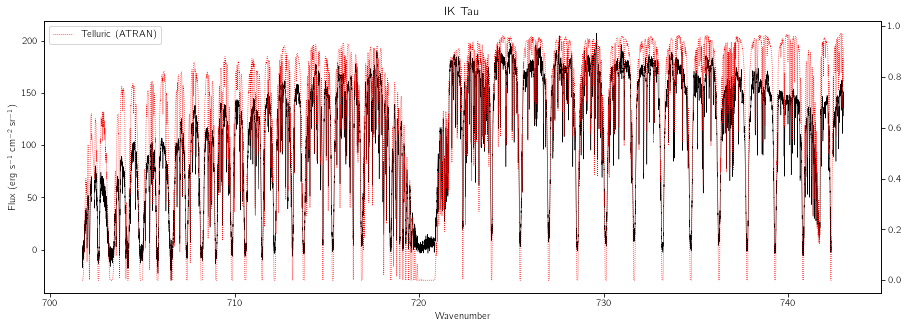

In [7]:
# Plot the whole spectrum
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber, flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)")
ax1.set_xlabel("Wavenumber")
plt.legend()
plt.title("IK Tau")
plt.show()

In [8]:
# load synthetic models for hot 1500 K H2O
water_model = Table.read(
    "../example_data/EXES/H2O_700to800_1500K_1.0e19_6kms.txt",
    format="ascii",
    names=("wavenumber", "flux"),
)

In [9]:
# inspect synthetic water model
water_model[0:5]

wavenumber,flux
float64,float64
700.0,1.0
700.001401,0.999999
700.002802,0.999998
700.004203,0.999993
700.005604,0.99998


In [10]:
# Function to plot specified xrange of spectrum
def plot_window(xmin, xmax):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 1, 1)

    # create second axis to overplot ATRAN
    ax2 = ax1.twinx()
    # hide axis labels and ticks
    ax2.set_yticks([])

    # plot data
    ax1.plot(wavenumber, flux, lw=0.5, c="k")

    # plot Atmospheric model (ATRAN)
    ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")

    # plot synthetic water model
    ax2.plot(
        water_model["wavenumber"],
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (1500\,K)",
    )

    # set axis labels
    ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)")
    ax1.set_xlabel("Wavenumber")

    # set x axis limits
    ax1.set_xlim(xmin, xmax)

    plt.legend(loc="lower left")
    plt.title("IK Tau")
    return fig, ax1, ax2

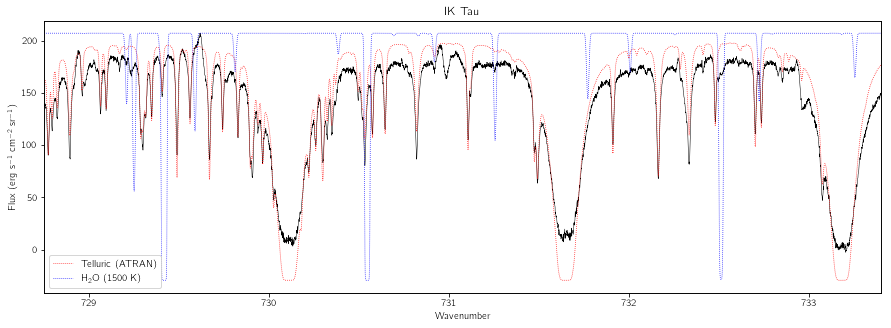

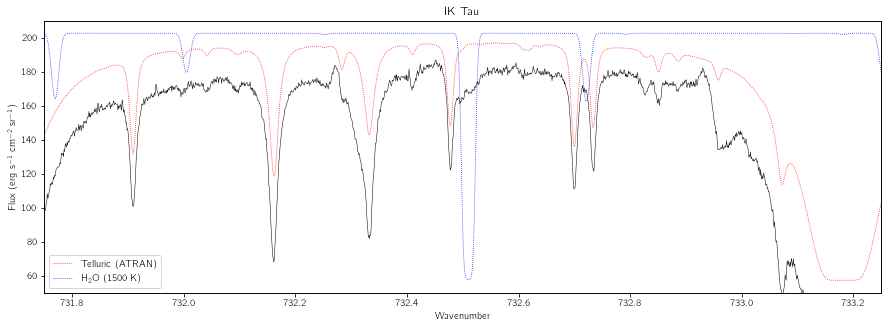

In [11]:
# Spectral window plots
fig, ax1, ax2 = plot_window(728.75, 733.4)
plt.show()

fig, ax1, ax2 = plot_window(731.75, 733.25)
ax1.set_ylim(50, 210)
plt.show()

We see evidence of a water absorption feature around a wavenumber of 732.5.

To subtract out the effects of the atmosphere we need to do a better job of modeling and fitting the target spectrum. 

See the EXES: Telluric Correction notebook for more details on this process. 